<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Experiments/tinyimagenet_resnet50_cutout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 21 15:31:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

--2022-05-21 15:31:30--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  16.5MB/s    in 18s     

2022-05-21 15:31:49 (12.8 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

test  train  val  wnids.txt  words.txt


In [ ]:
import json
import os
import torch


In [ ]:

training_data_list = []
for folder in os.listdir('./tiny-imagenet-200/train/'):
  label = folder  # The name of the folder is the label of the images it contains
  for file in os.listdir('./tiny-imagenet-200/train/' + folder + '/images/'):
    file_dir = './tiny-imagenet-200/train/' + folder + '/images/' + file
    training_data_list.append((file_dir, label))
with open('./training_data_list.json', 'w') as f:
  json.dump(training_data_list, f)

testing_data_list = []
with open('./tiny-imagenet-200/val/val_annotations.txt', 'r') as f:
  for line in f.readlines():
    file, label = line.split()[0:2]
    file_dir = './tiny-imagenet-200/val/images/' + file
    testing_data_list.append((file_dir, label))

with open('./testing_data_list.json', 'w') as f:
  json.dump(testing_data_list, f)

In [ ]:
with open('./tiny-imagenet-200/wnids.txt', 'r') as f :
  label_id = f.readlines()
label_id = [i[:-1] for i in label_id]
len(label_id)

200

In [ ]:

from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.dataloader import *
import cv2 # OpenCV


In [ ]:
class TinyImageDataset(Dataset):
  def __init__ (self, data, transform) :
    
    self.data = data
    self.transform = transform

  def __getitem__(self, index):
    img_path, label = self.data[index]
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
    if self.transform is not None:
      img = self.transform(img)
    return img, label_id.index(label)

  def __len__(self):
    return len(self.data)

In [ ]:
file_name='./training_data_list.json'
with open(file_name, 'r') as f:
  data = json.load(f)

In [ ]:
batch_size = 256
transform = transforms.Compose(
    [transforms.ToTensor()])

In [ ]:
from sklearn.model_selection import train_test_split


train_dataset = TinyImageDataset(data = data, transform = transform)
train_set, valid_set = train_test_split(train_dataset, test_size=0.2)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

batch = next(iter(train_loader))
images, labels = batch


class labels: tensor([121, 188,  40, 193,   9,  15, 151, 196,  88,  29,  53, 180,  53, 153,
        140,  96, 196,  21,  17, 110,  24, 152,  31, 107,  56, 110, 159, 167,
         89, 156, 159, 195, 165,  68, 144,  37,  48,  62, 142, 194,  89,  22,
         66,  64,  41, 129, 123, 118,   4,  81,  50,  75,  81,  20,  44,  40,
        125,  61, 167,  75,  45,  80, 111, 171, 184,  18,  60,  56,  48,  45,
        131,  75,  96, 118, 110,  71, 123,  19, 113, 111, 137, 159,   5,  64,
        110,  44, 114,  25,  72, 106, 118,  88,   1,  27,  23, 110, 164,  56,
         61, 125,  29, 172, 135,  87,  78,  62,  90, 122,  89, 196,  72,  21,
        110,   6,  91, 198, 100, 177,   1,  39,  78, 179, 127,  81, 111, 187,
         12, 168, 181,  14, 128, 131, 122,   8,  29, 188, 192, 176, 147,  85,
         16,  36,  18, 146,   2, 132, 121,  92,  44, 105,  81,  49,  81, 195,
        101,  74,   7, 161,  93, 140, 132, 125,  72,  24, 187, 183,  57,  25,
         94, 141,  31, 114, 154,  73,  80, 103, 17

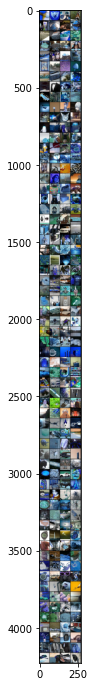

In [ ]:
import matplotlib.pyplot as plt
import torchvision

plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

In [ ]:
import numpy as np

def cut(W,H,lam):
        
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
images, labels = next(iter(train_loader))
rand_index = torch.randperm(images.shape[0])
shuffled_images = images[rand_index]
lam = np.random.beta(1.0, 1.0)
cutmix_images = images.clone().detach()
cutout_images = images.clone().detach() 
mixup_images = images.clone().detach() 

bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix

In [ ]:
## CUTMIX ##
cutmix_images[:, :, bbx1:bbx2, bby1:bby2] = cutmix_images[rand_index, :, bbx1:bbx2, bby1:bby2]
## CUTOUT ##
cutout_images[:, :, bbx1:bbx2, bby1:bby2] = 0.
## MIXUP ##
mixup_images = lam * mixup_images + (1 - lam) * mixup_images[rand_index,:,:]

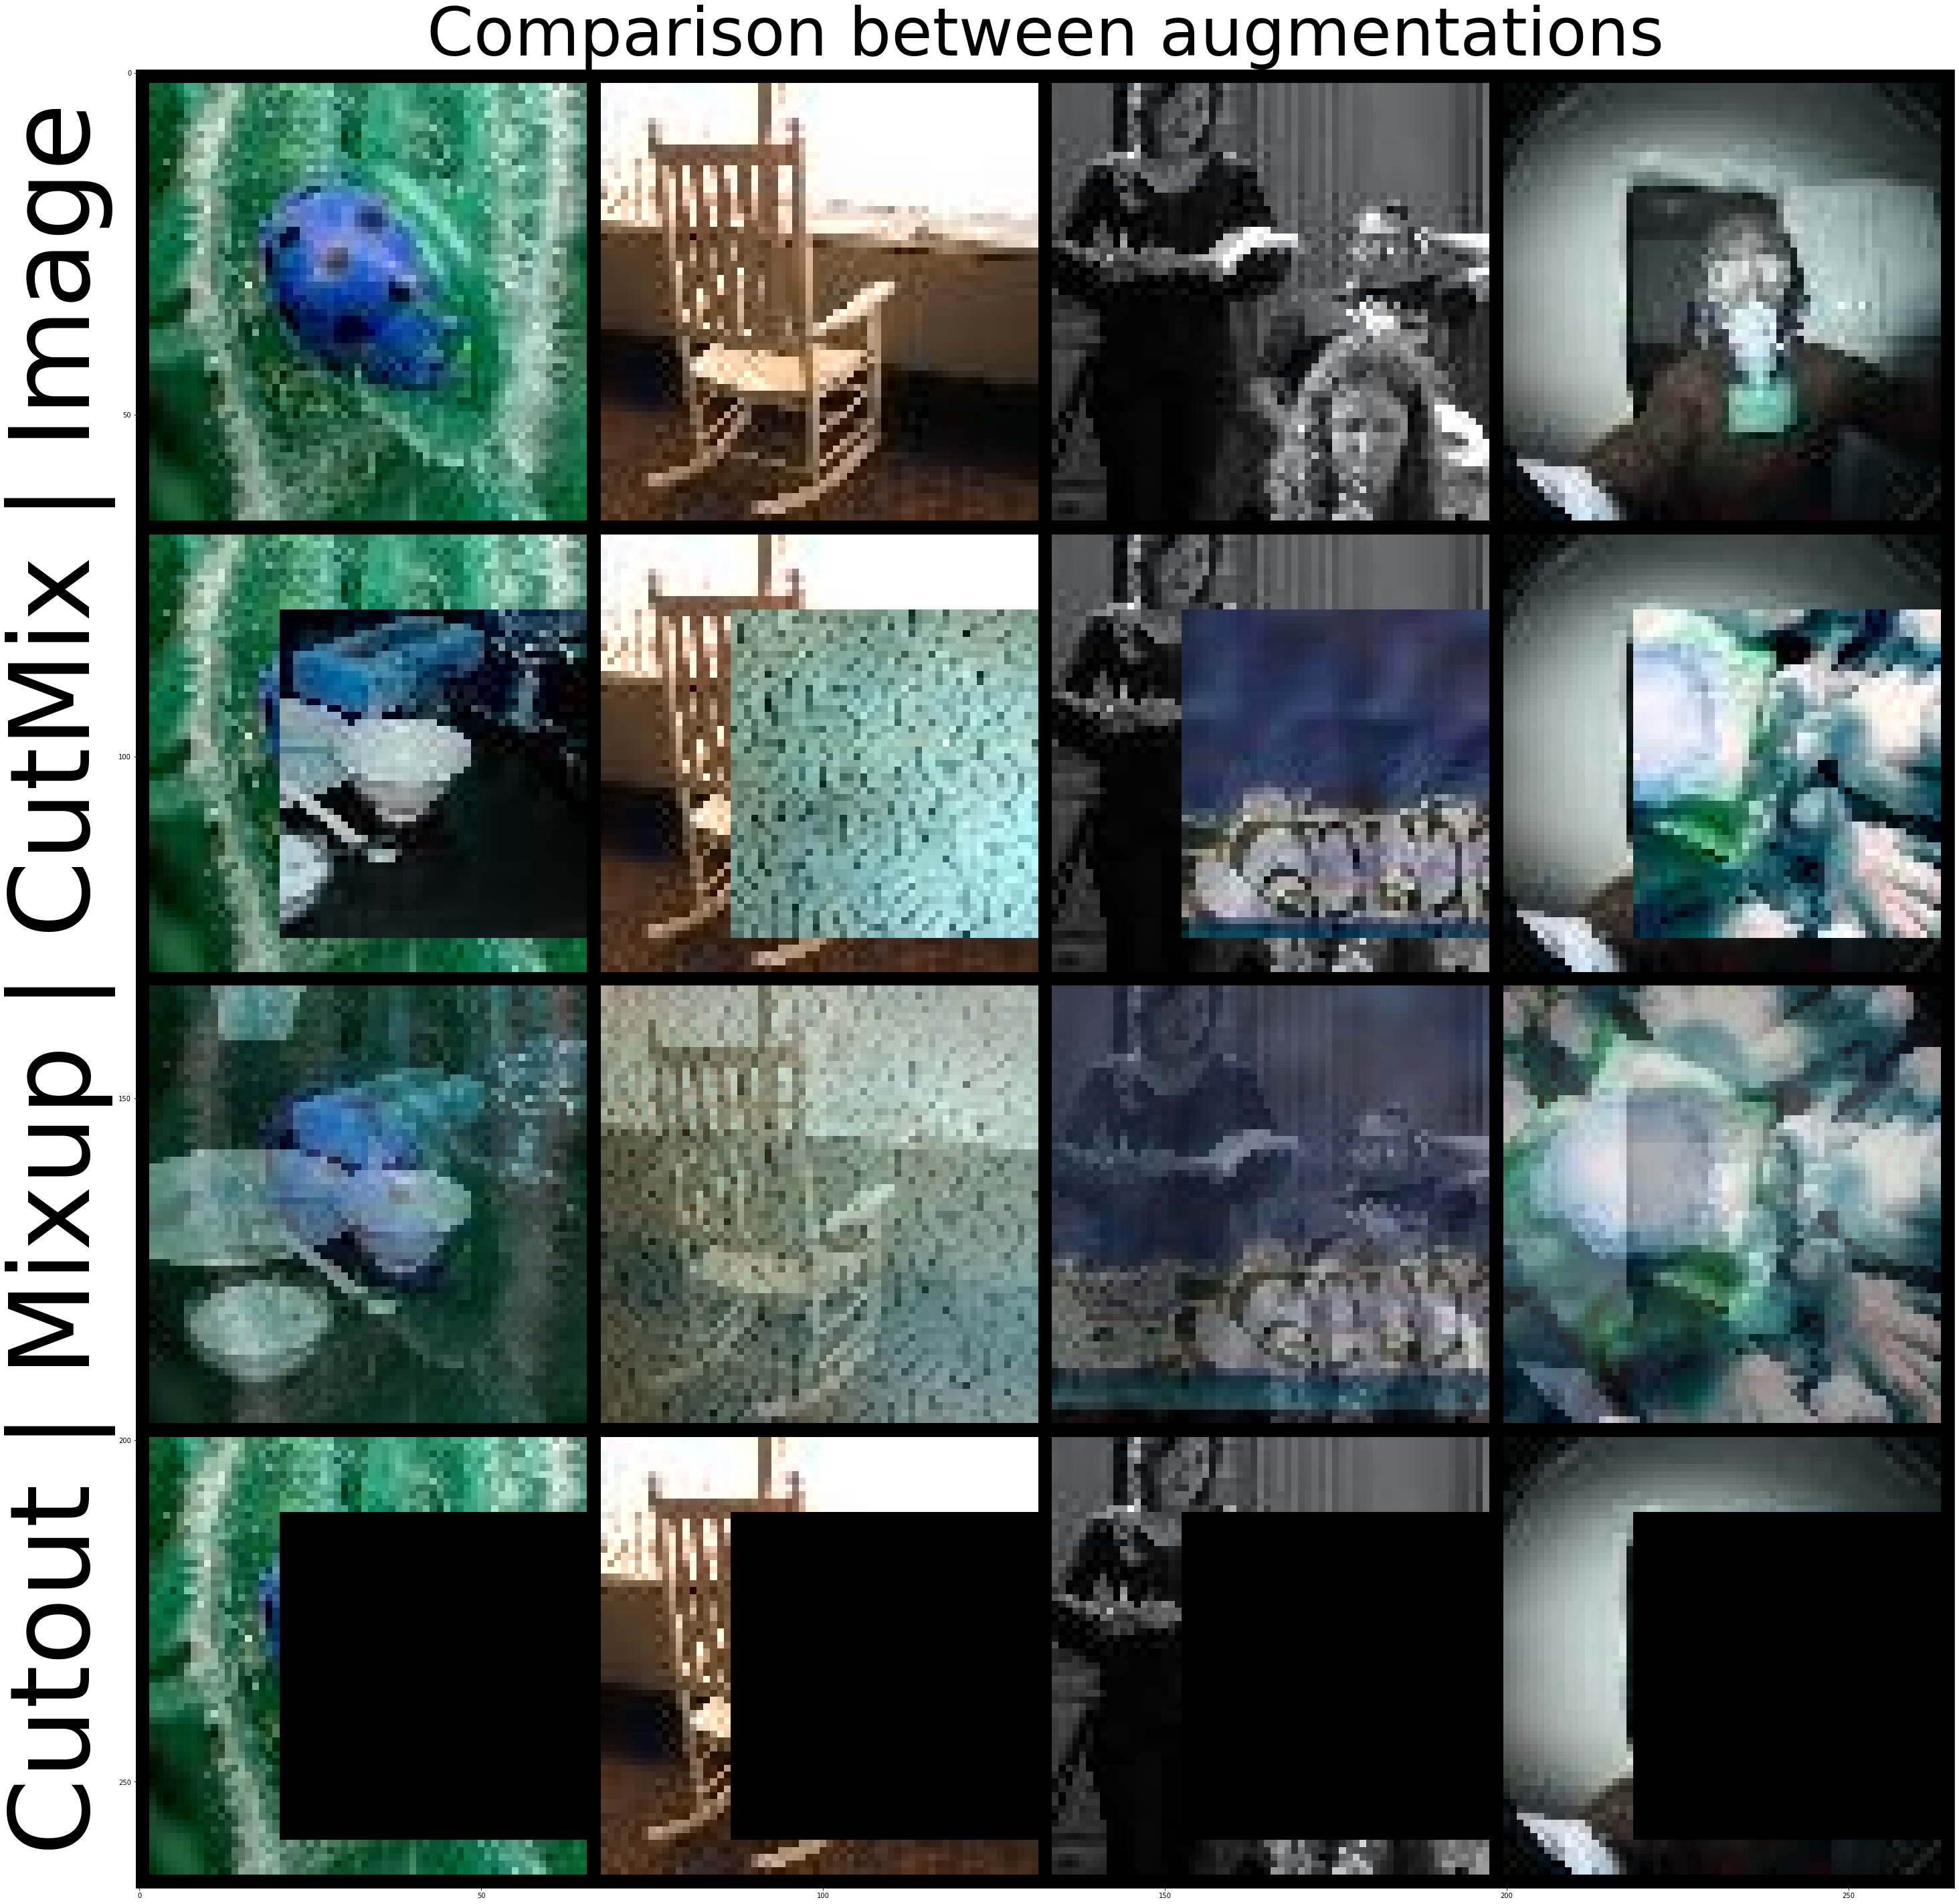

In [ ]:
  
def show_cutMixed_compare(row1, row2, row3, row4, nums_show):
    rand_index = torch.randperm(row1.size()[0])[:nums_show]
    to_compare = torch.cat([row1[rand_index,:,:],row2[rand_index,:,:],row3[rand_index,:,:],row4[rand_index,:,:]],dim=0)
    plt.figure(figsize=(50,50))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.ylabel("Cutout | Mixup | CutMix | Image",fontsize=165, rotation = 90)
    plt.title("Comparison between augmentations", fontsize=100)
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(images, cutmix_images, mixup_images, cutout_images, 4)

In [ ]:
from torch.nn import Linear
from torchvision import models

# resnet50 Model Loading
use_pretrained = False
model = models.resnet50(pretrained=use_pretrained)
## 우리 이미지 사이즈에 맞게 튜닝

model.fc = torch.nn.Linear(2048, len(labels)) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

cuda


In [ ]:
import torch.optim as optim
import torch.nn as nn
from tqdm.auto import tqdm, trange

    
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))
    return res
    
def train_model(model, 
                train, 
                valid,
                resume = None,
                n_iters=300, 
                learn_rate=0.1, 
                weight_decay=0, 
                which_method=0
                ):  # Lists to store model's performance information
  po = 0
  top1_errs, top5_errs = [], []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

###############Checkpoint Zone################
  if resume is not None :
    checkpoint = torch.load(resume) 
    model.load_state_dict(checkpoint['model_state_dict'])
    loss = checkpoint['loss']
    num_epochs = checkpoint['total_epochs'] - checkpoint['epoch']
    top1_errs = checkpoint['top1_err']
    top5_errs = checkpoint['top5_err']
  else :
    num_epochs = n_iters
###############Checkpoint Zone###############
  
  print(f"We still have to go {num_epochs} epochs" )
  for i in trange(num_epochs):

    ##############################learning_decay#####################################
    if (num_epochs-i) < 75 :
      newpo = 3
    elif (num_epochs-i) < 150 :
      newpo = 2
    elif (num_epochs-i) < 225 :
      newpo = 1
    else :
      newpo = 0
    if po != newpo :
      po = newpo
      lr = learn_rate * (0.1 ** po) ##learning_decay
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    ##############################learning_decay#####################################

    try :
      for images, labels in tqdm(train) :

        images, labels = images.to(device), labels.to(device)
        model.train() # For Dropout and Batch Norm layers #

        if which_method and (np.random.rand()<0.5) :

          lam = np.random.beta(1.0, 1.0)
          rand_index = torch.randperm(images.size()[0])
          shuffled_labels = labels[rand_index]

          ##############Do Something On Data###############
          if which_method == 1 : ##cutmix
            bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[-1] * images.shape[-2]))
          if which_method == 2 : ##mixup
            images = lam * images + (1 - lam) * images[rand_index,:,:]
          if which_method == 3 : ##cutout
            bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
            images[:, :, bbx1:bbx2, bby1:bby2] = 0.
          ##############Do Something On Data###############

          #############Forward Pass##############
          out = model(images) 
          #############Forward Pass##############

          ##############Modify Loss Function###############
          if which_method == 1 : ##cutmix
            loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam) # compute the total loss
          if which_method == 2 : ##mixup
            loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam)
          if which_method == 3 : ##cutout
            loss = criterion(out, labels)
          ##############Modify Loss Function###############

        else : ## if random.rand > 0.5 or which_method == 0
          
          out = model(images)
          loss = criterion(out, labels)

        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # reset the gradients for the next iteration
      
      #####################model Evaluation#############
      model.eval()
      sum_top1, sum_top5 = 0,0

      for images, labels in valid :
        images,labels = images.to(device), labels.to(device)
        output = model(images)
        top1, top5 = accuracy(output, labels, topk=(1,5))
        sum_top1+=top1.item()
        sum_top5+=top5.item()

      size = len(valid)
      #####################model Evaluation#############

      ###################save history#####################
      top1_errs.append(sum_top1/size)
      top5_errs.append(sum_top5/size)
      ###################save history#####################

      if (i+1) % 10 == 0 :

        PATH=f"./{300-(num_epochs-i)}th_checkpoint.pt"
        torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
        'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs }, PATH)
        print(f"Successfully saved untill {i} step in {PATH} with model, optimizer, and loss.")

    except :
      PATH=f"./{300-(num_epochs-i)}th_checkpoint.pt"
      torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
      'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs }, PATH)
      print(f"Successfully saved untill {i} step in {PATH} with model, optimizer, and loss.")
      return [top1_errs,top5_errs]

  PATH = "./trained.pt"
  print("train finished")
  print(f"Successfully saved untill {n_iters} step in {PATH} with model, optimizer, and loss.")
  torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
  'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs}, PATH)
  return [top1_errs,top5_errs]


In [ ]:
##You should run this cell ONLY FIRST TIME!!!
##Otherwise It will OverWrite your Checkpoint file.

logs = train_model(model, train_loader, valid_loader, n_iters=300, 
                    learn_rate=0.1, 
                    weight_decay=0, which_method=3) 

#which method 
# 0: nothing, 
# 1: cutmix, 
# 2: mixup 
# 3: cutout

We still have to go 300 epochs


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 9 step in ./9th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 19 step in ./19th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 29 step in ./29th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 39 step in ./39th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 49 step in ./49th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 59 step in ./59th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 69 step in ./69th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 79 step in ./79th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 89 step in ./89th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 99 step in ./99th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 109 step in ./109th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 119 step in ./119th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 129 step in ./129th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 139 step in ./139th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 149 step in ./149th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 159 step in ./159th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 169 step in ./169th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 179 step in ./179th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 189 step in ./189th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 199 step in ./199th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 209 step in ./209th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 219 step in ./219th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 229 step in ./229th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 239 step in ./239th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 249 step in ./249th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 259 step in ./259th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 269 step in ./269th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 279 step in ./279th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 289 step in ./289th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Successfully saved untill 299 step in ./299th_checkpoint.pt with model, optimizer, and loss.
train finished
Successfully saved untill 300 step in ./trained.pt with model, optimizer, and loss.


In [ ]:
## Chek point load 요령 ##
PATH="_" ## Where checkpoint saved. ## saved checkpoint

train_model(model,
            train_loader, 
            valid_loader,
            n_iters=300, 
            learn_rate=0.1, 
            resume=PATH,
            weight_decay=0, 
            which_method=3) 

Successfully saved untill 0 step in ./checkpoint.pt with model, optimizer, and loss.


[]

## Evaluate

In [ ]:
## If train was succeed, let's evaluate it.

In [ ]:
PATH="./trained.pt"
checkpoint = torch.load(PATH) 
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
sum_top1, sum_top5 = 0,0

for images, labels in valid_loader :
    images,labels = images.to(device), labels.to(device)
    output = model(images)
    top1, top5 = accuracy(output, labels, topk=(1,5))
    sum_top1+=top1.item()
    sum_top5+=top5.item()

size = len(valid_loader)

print(sum_top1/size, sum_top5/size)

71.37064873417721 48.714398734177216


In [ ]:
checkpoint['top1_err']

[98.9814082278481,
 97.18651107594937,
 95.18393987341773,
 92.59790348101266,
 89.32456487341773,
 86.85719936708861,
 85.97705696202532,
 84.51344936708861,
 81.56151107594937,
 82.11036392405063,
 83.46518987341773,
 76.59216772151899,
 75.90981012658227,
 75.77136075949367,
 77.12618670886076,
 75.03461234177215,
 76.87401107594937,
 75.16317246835443,
 74.20886075949367,
 74.15941455696202,
 76.35977056962025,
 75.4054588607595,
 75.63785601265823,
 74.83682753164557,
 75.28678797468355,
 74.69837816455696,
 73.9962420886076,
 73.68967563291139,
 75.10383702531645,
 75.50929588607595,
 74.68354430379746,
 75.97409018987342,
 74.14458069620254,
 73.71439873417721,
 75.89992088607595,
 74.79232594936708,
 73.60067246835443,
 73.76878955696202,
 74.29291930379746,
 73.28916139240506,
 73.6056170886076,
 74.52037183544304,
 85.3787579113924,
 72.71558544303798,
 73.23971518987342,
 72.9628164556962,
 73.17543512658227,
 73.48200158227849,
 73.97151898734177,
 72.7551424050633,
 73.249

https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py